# Práctica de Machine Learning
### Preprocesado y entrenamiento

Comenzamos importando las librerías y cargando los datos que me he quedado para hacer el entrenamiento.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

train = pd.read_csv('./train.csv',sep=';', decimal='.')

Antes de nada me voy a sacar una matriz de correlación para hacer una primera limpieza superficial, ya que tengo demasiadas variables.

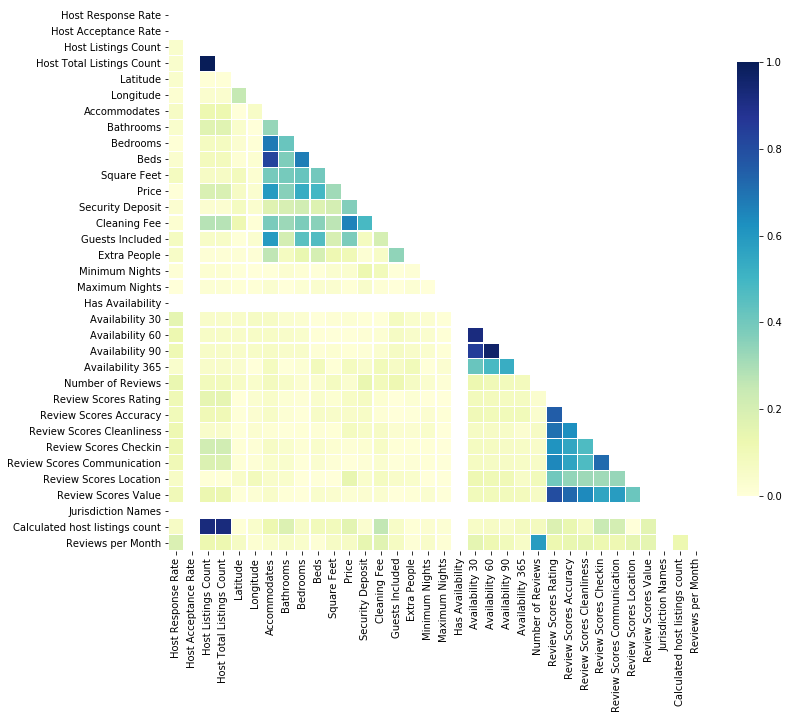

In [2]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(train.corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Availability 30, 60 y 90 me indican prácticamente lo mismo (disponibilidad a medio/largo plazo). Me quedaré únicamente con avaiability 60 por ser la que está en medio.

In [3]:
train = train.drop(columns=['Availability 30', 'Availability 90'])

Host Listings Count, Host Total Listings Count y Calculated host listings count también parecen indicarme algo similar. Me quedo con la primera de las tres, ya que las otras dos parecen haber sido calculadas a posteriori.

In [4]:
train = train.drop(columns=['Host Total Listings Count','Calculated host listings count'])

Beds y accomodates también parecen hacer referencia a lo mismo (camas o muebles "para quedarse a dormir"). Me quedo con accomodates ya que a priori parece más preciso y además tiene una correlación más alta con la variable objetivo.

In [5]:
train = train.drop(columns=['Beds'])

Review Scores Rating, Review Scores Value y Review Scores Accuracy también tienen valores muy similares en relación al precio.

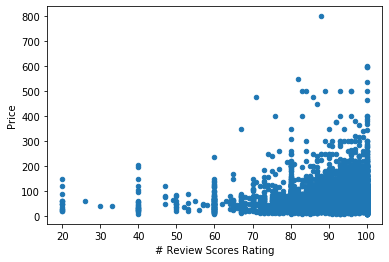

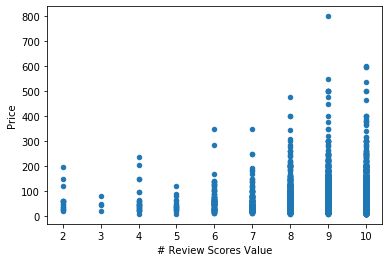

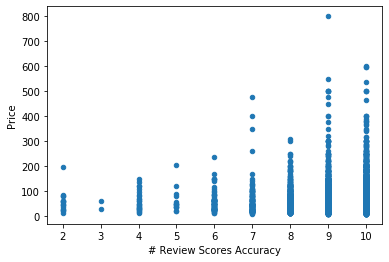

In [6]:
train.plot(kind='scatter', x='Review Scores Rating', y='Price')
plt.xlabel('# Review Scores Rating')
plt.ylabel('Price')
plt.show()

train.plot(kind='scatter', x='Review Scores Value', y='Price')
plt.xlabel('# Review Scores Value')
plt.ylabel('Price')
plt.show()

train.plot(kind='scatter', x='Review Scores Accuracy', y='Price')
plt.xlabel('# Review Scores Accuracy')
plt.ylabel('Price')
plt.show()

In [7]:
print(f"NaN en Review Scores Rating: {sum(train['Review Scores Rating'].isnull())}\n"+
      f"Nan en Review Scores Value: {sum(train['Review Scores Value'].isnull())}\n"+
      f"Nan en Review Scores Accuracy: {sum(train['Review Scores Accuracy'].isnull())}")

NaN en Review Scores Rating: 2265
Nan en Review Scores Value: 2287
Nan en Review Scores Accuracy: 2280


No tengo muy claro cuál de las tres me va a dar los mejores resultados, así que me quedaré con la primera por ser la que menos valores nulos contiene.

In [8]:
train = train.drop(columns=['Review Scores Value','Review Scores Accuracy'])

Review Scores Checkin y Review Scores Communication también están muy correlacionadas

In [9]:
print(f"NaN en Review Scores Checkin: {sum(train['Review Scores Checkin'].isnull())}\n"+
      f"Nan en Review Scores Communication: {sum(train['Review Scores Communication'].isnull())}")

NaN en Review Scores Checkin: 2287
Nan en Review Scores Communication: 2276


In [10]:
# Me baso en lo mismo que antes
train = train.drop(columns=['Review Scores Checkin'])

Hago un segundo repaso sobre las variables que tengo para decidir qué hacer con ellas.

In [11]:
train.columns

Index(['Last Scraped', 'Experiences Offered', 'Host Since',
       'Host Response Time', 'Host Response Rate', 'Host Acceptance Rate',
       'Host Neighbourhood', 'Host Listings Count', 'Host Verifications',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'Zipcode', 'Market', 'Smart Location',
       'Latitude', 'Longitude', 'Property Type', 'Room Type', 'Accommodates',
       'Bathrooms', 'Bedrooms', 'Bed Type', 'Amenities', 'Square Feet',
       'Price', 'Security Deposit', 'Cleaning Fee', 'Guests Included',
       'Extra People', 'Minimum Nights', 'Maximum Nights', 'Calendar Updated',
       'Has Availability', 'Availability 60', 'Availability 365',
       'Calendar last Scraped', 'Number of Reviews', 'First Review',
       'Last Review', 'Review Scores Rating', 'Review Scores Cleanliness',
       'Review Scores Communication', 'Review Scores Location', 'License',
       'Jurisdiction Names', 'Cancellation Policy', 'Reviews per Month',
     

In [12]:
# Elimino Geolocation por ser redundante con Latitude y Longitude
train = train.drop(columns=['Geolocation'])

In [13]:
train['Cancellation Policy'].value_counts()

strict             3972
flexible           3389
moderate           3198
super_strict_60       3
super_strict_30       2
Name: Cancellation Policy, dtype: int64

Asignaré un valor asumiendo que las políticas de cancelación más estrictas se le dan a los alquileres más caros.

In [14]:
train['Cancellation Policy'] = train['Cancellation Policy'].apply(lambda x: {
    'super_strict_60': 4,
    'super_strict_30': 4,
    'strict': 4,
    'moderate': 2,
    'flexible': 1,
}.get(x))

In [15]:
print(train.License.value_counts(),'\n',
    f'Nulls: {sum(train.License.isnull())}',sep='\n')

VT1046       3
VT411        2
VT-2043      2
VT1003       2
VT-1521      1
            ..
VT-2450      1
VT-724       1
VT-477       1
VT-219       1
VT - 2184    1
Name: License, Length: 194, dtype: int64


Nulls: 10365


In [16]:
# Esta variable me la cargo directamente
train = train.drop(columns=['License'])

Relleno los NaN de Bedrooms en base al tipo de vivienda, basándome en lo que es más común.

In [17]:
train['Bedrooms'].value_counts()

1.0     7133
2.0     1866
0.0      738
3.0      588
4.0      159
5.0       36
6.0        9
7.0        6
8.0        5
10.0       3
Name: Bedrooms, dtype: int64

In [18]:
train.loc[train['Bedrooms'].isnull(), 'Property Type'].value_counts()

Apartment          11
House               6
Boutique hotel      1
Bed & Breakfast     1
Condominium         1
Loft                1
Name: Property Type, dtype: int64

In [19]:
train.loc[train['Bedrooms'].isnull(), 'Bedrooms'] = train.loc[train['Bedrooms'].isnull(), 'Property Type'].apply(
    lambda x: 2 if x == 'House' else
    0 if x == 'Loft' else 1)

Le doy un valor a Calendar Updated en base a si el alquiler se actualizó hace poco o no.

In [20]:
train['Calendar Updated'] = train['Calendar Updated'].apply(lambda x: 5 if "today" in str(x) else
                                                           4 if "yesterday" in str(x) else
                                                           3 if "day" in str(x) else
                                                           2 if "week" in str(x) else
                                                           1 if "month" in str(x) else 0)

Me transformo los pies cuadrados a metros cuadrados, ya que es una medida que controlo mejor.

In [21]:
train['Square Meters'] = train['Square Feet']*0.092903
train = train.drop(columns=['Square Feet'])

Hay ciertos datos que no tienen sentido. Por ejemplo no puede haber pisos con 0m, y un piso con dos habitaciones que mida menos de 30m o un piso con menos de 15m también serían casos practicamente imposibles.

In [22]:
train.loc[train['Square Meters'] < 15, 'Square Meters'] = np.nan
train.loc[(train['Square Meters'] < 30) & (train['Bedrooms'] > 1) , 'Square Meters'] = np.nan

In [23]:
train['Square Meters'] = train['Square Meters'].fillna(train['Square Meters'].mean())

In [24]:
print(f"Apartment: {train[train['Property Type']=='Apartment']['Price'].describe()}",
     f"House: {train[train['Property Type']=='House']['Price'].describe()}",
     f"Condominium: {train[train['Property Type']=='Condominium']['Price'].describe()}",
     f"Bed & Breakfast: {train[train['Property Type']=='Bed & Breakfast']['Price'].describe()}",
     f"Loft: {train[train['Property Type']=='Loft']['Price'].describe()}",
     f"Other: {train[train['Property Type']=='Other']['Price'].describe()}",
     f"Dorm: {train[train['Property Type']=='Dorm']['Price'].describe()}",
     f"Guesthouse: {train[train['Property Type']=='Guesthouse']['Price'].describe()}",
     f"Chalet: {train[train['Property Type']=='Chalet']['Price'].describe()}",
     f"Hostel: {train[train['Property Type']=='Hostel']['Price'].describe()}",
     f"Serviced apartment: {train[train['Property Type']=='Serviced apartment']['Price'].describe()}", sep='\n\n')

Apartment: count    8724.000000
mean       67.652797
std        55.174927
min        10.000000
25%        33.000000
50%        55.000000
75%        82.000000
max       800.000000
Name: Price, dtype: float64

House: count    775.000000
mean      57.541935
std       61.830501
min        9.000000
25%       25.000000
50%       39.000000
75%       69.000000
max      750.000000
Name: Price, dtype: float64

Condominium: count    266.000000
mean      62.710526
std       54.826956
min       10.000000
25%       30.000000
50%       50.000000
75%       74.250000
max      550.000000
Name: Price, dtype: float64

Bed & Breakfast: count    253.000000
mean      37.984190
std       42.164452
min       15.000000
25%       24.000000
50%       30.000000
75%       45.000000
max      650.000000
Name: Price, dtype: float64

Loft: count    229.000000
mean      75.301310
std       62.320838
min       17.000000
25%       48.000000
50%       60.000000
75%       85.000000
max      750.000000
Name: Price, dtype: fl

Basándome en los datos y un poco en mi intuición establezco cuatro categorías según la relación del tipo de vivienda con el precio.

In [25]:
# Gama alta: Chalet
# Gama media-alta: Apartment, Condominium, Loft, Other
# Gama media: House, Serviced apartment
# Gama baja: Bed & Breakfast, Dorm, Guesthouse, Hostel

train['Property Type'] = train['Property Type'].apply(lambda x: {
    'Bed & Breakfast': 1,
    'Dorm': 1,
    'Guesthouse': 1,
    'Hostel': 1,
    'House': 2,
    'Serviced apartment': 2,
    'Apartment': 3,
    'Condominium': 3,
    'Loft': 3,
    'Other': 3,
    'Chalet': 4
}.get(x))

train.loc[train['Property Type'].isnull(), 'Property Type'] = 0

Aplico la misma lógica a Room Type, aunque aquí me fiaré de mi intuición, ya que la diferencia de calidad se hace más evidente.

In [26]:
train['Room Type'] = train['Room Type'].apply(lambda x: {
    'Shared room': 1,
    'Private room': 2,
    'Entire home/apt': 3
}.get(x))

Hago lo mismo con Bed Type

In [27]:
train['Bed Type'] = train['Bed Type'].apply(lambda x: {
    'Real Bed': 3,
    'Pull-out Sofa': 2,
    'Futon': 1,
    'Couch': 2
}.get(x))

train.loc[train['Bed Type'].isnull(), 'Bed Type'] = 0

In [28]:
train['Hosting Type'] = train['Property Type']+train['Bed Type']
train[['Property Type','Room Type','Bed Type','Hosting Type','Price']].corr()

,Property Type,Room Type,Bed Type,Hosting Type,Price
Property Type,1.000000,0.265776,-0.013804,0.926634,0.089246
Room Type,0.265776,1.000000,-0.004229,0.246066,0.460360
Bed Type,-0.013804,-0.004229,1.000000,0.363137,0.038751
Hosting Type,0.926634,0.246066,0.363137,1.000000,0.097732
Price,0.089246,0.460360,0.038751,0.097732,1.000000


Room Type me lo guardo como oro en paño y de momento me quedo también con Hosting Type a ver qué tal.

In [29]:
train = train.drop(columns=['Property Type','Bed Type'])

Establezco un orden de valores para cada una de las variables de Host Response Time, dando una mayor puntuación a los que tienen el tiempo de respuesta más bajo

In [30]:
train['Host Response Time'] = train['Host Response Time'].apply(lambda x: {
    'a few days or more': 1,
    'within a day': 2,
    'within a few hours': 3,
    'within an hour': 4
}.get(x))

train.loc[train['Host Response Time'].isnull(), 'Host Response Time'] = 0

In [31]:
train['Host Response'] = train['Host Response Rate']*train['Host Response Time']
train[['Host Response','Host Response Time','Host Response Rate','Price']].corr()

,Host Response,Host Response Time,Host Response Rate,Price
Host Response,1.000000,0.976040,0.741107,0.023907
Host Response Time,0.976040,1.000000,0.612391,0.053232
Host Response Rate,0.741107,0.612391,1.000000,-0.006232
Price,0.023907,0.053232,-0.006232,1.000000


In [32]:
# Me quedo con Host Response Time de momento.
train = train.drop(columns=['Host Response','Host Response Rate'])

Hay tres variables que parecen indicar el barrio. Una parece originaria del scrap y dos de ellas parecen haber sido creadas a posteriori. De momento las transformaré todas y después analizaré cual de las tres me podría dar mejores resultados.

In [33]:
from sklearn.preprocessing import LabelEncoder

train['Neighbourhood'] = train['Neighbourhood'].fillna('Unknown')
train['Neighbourhood Cleansed'] = train['Neighbourhood Cleansed'].apply(lambda x: 'Unknown' if x == 'Orcasitas' else x)
train['Neighbourhood Group Cleansed'] = train['Neighbourhood Group Cleansed'].apply(lambda x: 'Unknown' if x == 'Vicálvaro' else x)

# Me guardo los valores para después poder hacer el chequeo con test
checkneigh = train['Neighbourhood'].unique()
checkneighcl = train['Neighbourhood Cleansed'].unique()
checkneigrocl = train['Neighbourhood Group Cleansed'].unique()

encoderNeigh = LabelEncoder().fit(list(train['Neighbourhood'].unique()))
encoderNeighCl = LabelEncoder().fit(list(train['Neighbourhood Cleansed'].unique()))
encoderNeighGCl = LabelEncoder().fit(list(train['Neighbourhood Group Cleansed'].unique()))

train['Neighbourhood'] = encoderNeigh.transform(train['Neighbourhood'])
train['Neighbourhood Cleansed'] = encoderNeighCl.transform(train['Neighbourhood Cleansed'])
train['Neighbourhood Group Cleansed'] = encoderNeighGCl.transform(train['Neighbourhood Group Cleansed'])

train[['Neighbourhood','Neighbourhood Cleansed','Neighbourhood Group Cleansed','Price']].corr()

,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,Price
Neighbourhood,1.000000,0.396318,-0.008875,0.003483
Neighbourhood Cleansed,0.396318,1.000000,-0.170739,0.055217
Neighbourhood Group Cleansed,-0.008875,-0.170739,1.000000,-0.037512
Price,0.003483,0.055217,-0.037512,1.000000


In [34]:
# Ninguna de ellas parece importante.
# Neighbourhood tiene demasiados valores nan
# Neighbourhood Group Cleansed parece una agrupación que no sé de dónde sale.
# De momento me quedo con Neighbourhood Cleansed.

train = train.drop(columns=['Neighbourhood','Neighbourhood Group Cleansed'])

In [35]:
print(train[train['Market']=='Madrid']['Price'].describe(),
      train[train['Market']=='Other (International)']['Price'].describe(),
      train[(train['Market']=='Toledo') | (train['Market']=='Deauville')]['Price'], sep='\n\n')

count    10519.000000
mean        65.983554
std         55.762622
min          9.000000
25%         30.000000
50%         52.000000
75%         80.000000
max        800.000000
Name: Price, dtype: float64

count      7.000000
mean     136.142857
std      205.643242
min       25.000000
25%       49.500000
50%       60.000000
75%       84.500000
max      600.000000
Name: Price, dtype: float64

3784    95.0
4276    35.0
Name: Price, dtype: float64


Casi todas las entradas están en el mercado de Madrid, y no veo que haya una clara diferencia en el margen de precios en ninguna de las variables, por lo que deduzco que esta caracteristica no me va a aportar nada.

In [36]:
train = train.drop(columns=['Market'])

Ciertas variables presentan una serie de características y de momento voy a asignarles un valor en función del número de características. Más adelante veré si esto me aporta información para predecir el precio o si son variables deshechables.

In [37]:
train['Host Verifications'] = train['Host Verifications'].apply(lambda x: len(str(x).split(',')))
train['Features'] = train['Features'].apply(lambda x: len(x.split(',')))
train['Amenities'] = train['Amenities'].apply(lambda x: len(str(x).split(',')))

In [38]:
# Codifico el resto de variables categóricas

train['Host Neighbourhood'] = train['Host Neighbourhood'].fillna('Unknown')

# Me guardo los valores para después poder hacer el chequeo con test
checkhostneigh = train['Host Neighbourhood'].unique()

encoderHostNeigh = LabelEncoder().fit(list(train['Host Neighbourhood'].unique()))

train['Host Neighbourhood'] = encoderHostNeigh.transform(train['Host Neighbourhood'])

In [39]:
# Relleno el resto de valores nan

train['Bathrooms'] = train['Bathrooms'].fillna(train['Bathrooms'].mode()[0])
train['Security Deposit'] = train['Security Deposit'].fillna(train['Security Deposit'].mean())
train['Cleaning Fee'] = train['Cleaning Fee'].fillna(train['Cleaning Fee'].mean())
train['Review Scores Rating'] = train['Review Scores Rating'].fillna(train['Review Scores Rating'].mean())
train['Review Scores Cleanliness'] = train['Review Scores Cleanliness'].fillna(train['Review Scores Cleanliness'].mean())
train['Review Scores Communication'] = train['Review Scores Communication'].fillna(train['Review Scores Communication'].mean())
train['Review Scores Location'] = train['Review Scores Location'].fillna(train['Review Scores Location'].mean())
train['Reviews per Month'] = train['Reviews per Month'].fillna(train['Reviews per Month'].mean())
train['Host Listings Count'] = train['Host Listings Count'].fillna(train['Host Listings Count'].mean())

Las siguientes variables las voy a deshechar por no presentar diferentes valores o por estar enteramente vacías

In [40]:
train = train.drop(columns=['Last Scraped', 'Experiences Offered', 'Host Acceptance Rate', 'Smart Location', 'Has Availability',
                            'Calendar last Scraped', 'Jurisdiction Names'])

La variable Accommodates está muy correlacionada con Bedrooms y Guests Included, y aplicando la lógica se puede deducir que el número de "muebles para dormir" debería ser más o menos equivalente al número de habitaciones más el número de invitados (más o menos porque en una habitación puede dormir más de una persona).

In [41]:
train['Calculated Accommodates'] = train['Bedrooms']+train['Guests Included']
train['Bath per occupant'] = train['Bathrooms']/train['Accommodates']
train[['Accommodates','Bedrooms','Guests Included','Calculated Accommodates','Bathrooms','Bath per occupant','Price']].corr()

,Accommodates,Bedrooms,Guests Included,Calculated Accommodates,Bathrooms,Bath per occupant,Price
Accommodates,1.000000,0.679354,0.590500,0.736277,0.333067,-0.512433,0.590238
Bedrooms,0.679354,1.000000,0.446558,0.801004,0.415835,-0.179083,0.532846
Guests Included,0.590500,0.446558,1.000000,0.893347,0.207597,-0.273328,0.381924
Calculated Accommodates,0.736277,0.801004,0.893347,1.000000,0.347740,-0.272817,0.523144
Bathrooms,0.333067,0.415835,0.207597,0.347740,1.000000,0.457309,0.357778
Bath per occupant,-0.512433,-0.179083,-0.273328,-0.272817,0.457309,1.000000,-0.268440
Price,0.590238,0.532846,0.381924,0.523144,0.357778,-0.268440,1.000000


Los resultados son interesantes pero no me mejoran lo que ya tenía en el dataset. En todo caso podría descartar Accommodates por contener información redundante en la suma de Bedrooms y Guests Included, pero como tampoco es una redundancia exacerbada y es una variable que parece decir más sobre Price que las otras, optaré por quedarme como estaba.

In [42]:
train = train.drop(columns=['Calculated Accommodates','Bath per occupant'])

Limpio Zipcode y la codifico

In [43]:
train.loc[train['Zipcode']=='28002\n28002', 'Zipcode'] = '28002'
train.loc[train['Zipcode']=='28051\n28051', 'Zipcode'] = '28051'
train.loc[train['Zipcode']=='Madrid 28004', 'Zipcode'] = '28004'

train.loc[train['Zipcode']=='280013', 'Zipcode'] = '28013'
train.loc[train['Zipcode']=='2804', 'Zipcode'] = '28004'
train.loc[train['Zipcode']=='2805', 'Zipcode'] = '28005'
train.loc[train['Zipcode']=='2815', 'Zipcode'] = '28015'

train['Zipcode'] = train['Zipcode'].apply(lambda x: '0' if len(str(x))!=5 else x)

# Me cargo todos los que no empiezen por 28 (obligatorio para Madrid)
train.loc[train['Zipcode'].astype(int)>28999, 'Zipcode'] = '0'
train.loc[train['Zipcode'].astype(int)<28000, 'Zipcode'] = '0'

# Me guardo los códigos postales para después poder hacer el chequeo con test
zipstocheck = train.Zipcode.unique()

encoderZipcode = LabelEncoder().fit(list(train['Zipcode'].unique()))

train['Zipcode'] = encoderZipcode.transform(train['Zipcode'])

En las variables de fecha que me quedan, puntuaré más alto los años más recientes y le daré un 0 a los que no tienen sentido

In [44]:
train['Host Since'] = train['Host Since'].fillna(0)
train['Host Since'] = train['Host Since'].apply(lambda x: int(str(x).split('-')[0])-2008)
train['Host Since'] = train['Host Since'].apply(lambda x: 0 if x not in range(0,10) else x)
train['Host Since'].value_counts()

7    2509
8    2365
6    1922
5    1390
4    1308
9     519
3     451
2      89
1       8
0       3
Name: Host Since, dtype: int64

In [45]:
train['First Review'] = train['First Review'].fillna(0)
train['First Review'] = train['First Review'].apply(lambda x: int(str(x).split('-')[0])-2009)
train['First Review'] = train['First Review'].apply(lambda x: 0 if x not in range(0,10) else x)
train['First Review'].value_counts()

7    3686
0    2159
6    2026
8    1091
5     870
4     454
3     220
2      52
1       6
Name: First Review, dtype: int64

In [46]:
train['Last Review'] = train['Last Review'].fillna(0)
train['Last Review'] = train['Last Review'].apply(lambda x: int(str(x).split('-')[0])-2011)
train['Last Review'] = train['Last Review'].apply(lambda x: 0 if x not in range(0,10) else x)
train['Last Review'].value_counts()

6    6121
0    2160
5    1867
4     350
3      50
2      14
1       2
Name: Last Review, dtype: int64

In [47]:
train['Date Reviews'] = train['First Review']*train['Last Review']
train[['Host Since','First Review','Last Review','Date Reviews','Price']].corr()

,Host Since,First Review,Last Review,Date Reviews,Price
Host Since,1.000000,0.022876,-0.151178,0.047760,-0.081092
First Review,0.022876,1.000000,0.914196,0.981559,-0.049263
Last Review,-0.151178,0.914196,1.000000,0.925996,-0.041320
Date Reviews,0.047760,0.981559,0.925996,1.000000,-0.046861
Price,-0.081092,-0.049263,-0.041320,-0.046861,1.000000


First Review y Last Review están muy correlacionadas así que me quedo con el producto de las dos.

In [48]:
train = train.drop(columns=['First Review','Last Review'])

In [49]:
train = train.apply(lambda x: pd.to_numeric(x))

Ahora que tengo todos los datos tratados y transformados a números, voy a pasar a realizar una selección de características, ya que sigo teniendo una dimensionalidad demasiado alta

In [50]:
X_train = train.loc[:, train.columns != 'Price']
y_train = train.Price

best mean cross-validation score: 0.670
best parameters: {'max_depth': 14}


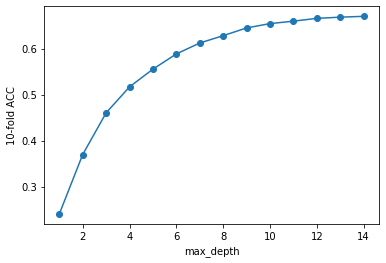

In [51]:
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor

maxDepth = range(1,15)
tuned_parameters = {'max_depth': maxDepth}

gridRFR = GridSearchCV(RandomForestRegressor(n_estimators=200, max_features='log2'), param_grid=tuned_parameters, cv=10) 
gridRFR.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(gridRFR.best_score_))
print("best parameters: {}".format(gridRFR.best_params_))

scores = np.array(gridRFR.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

In [52]:
maxDepthOptimo = gridRFR.best_params_['max_depth']
bagModel = RandomForestRegressor(max_depth=maxDepthOptimo-5,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

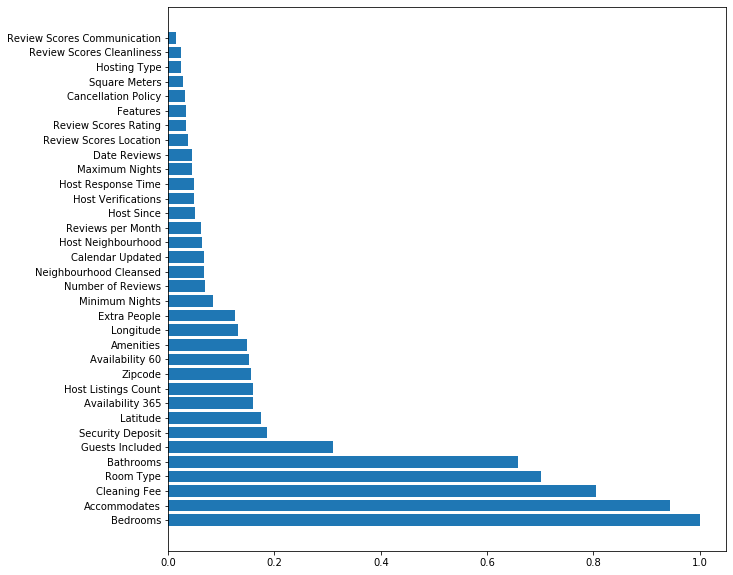

In [53]:
importances = bagModel.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),X_train.columns[indices])
plt.show()

Vamos a comparar con Lasso a ver qué tal.

best mean cross-validation score: -1363.385
best parameters: {'alpha': 1.0}


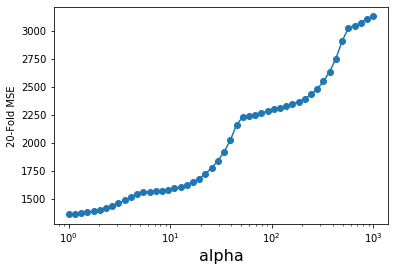

In [54]:
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(0,3,50)
param_grid = {'alpha': alpha_vector }
gridLas = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 20)
gridLas.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(gridLas.best_score_))
print("best parameters: {}".format(gridLas.best_params_))

scores = -1*np.array(gridLas.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('20-Fold MSE')
plt.show()

In [55]:
from sklearn.metrics import mean_squared_error

#alpha_optimo = gridLas.best_params_['alpha']
lasso = Lasso(alpha = 12).fit(X_train,y_train)

ytrainLasso = lasso.predict(X_train)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))

w = lasso.coef_
for f,wi in zip(X_train.columns,w):
    print(f,wi)

MSE Modelo Lasso (train): 1.59e+03
RMSE Modelo Lasso (train): 39.9
Host Since -0.0
Host Response Time -0.0
Host Neighbourhood 0.06098835857374683
Host Listings Count 0.07831280294121819
Host Verifications 0.0
Neighbourhood Cleansed 0.008943477613560617
Zipcode -0.4146180148694104
Latitude 0.0
Longitude 0.0
Room Type 0.0
Accommodates 10.014231283327126
Bathrooms 0.0
Bedrooms 0.0
Amenities 0.4869156337422721
Security Deposit 0.06126799818226681
Cleaning Fee 0.970604204915331
Guests Included 0.0
Extra People -0.0
Minimum Nights -0.0
Maximum Nights -0.00026246240068178515
Calendar Updated 0.0
Availability 60 0.07668686713916349
Availability 365 0.007693556186934132
Number of Reviews -0.0444168654705918
Review Scores Rating 0.2195945678284072
Review Scores Cleanliness 0.0
Review Scores Communication 0.0
Review Scores Location 0.0
Cancellation Policy -0.0
Reviews per Month -0.0
Features 0.0
Square Meters 0.0
Hosting Type 0.0
Date Reviews -0.137962728125044


Me cargo todas las variables con coeficiente de 0 o casi 0, salvo aquellos a los que se les dio mucha importancia con el Random Forest, y vuelvo a ejecutar los entrenamientos para ver cuál me da mejores resultados.

In [56]:
X_train = train[['Bedrooms','Accommodates','Cleaning Fee','Room Type','Bathrooms',
                 'Guests Included','Security Deposit','Host Listings Count',
                 'Availability 60','Number of Reviews','Host Neighbourhood',
                 'Zipcode','Amenities','Review Scores Rating','Date Reviews']]

best mean cross-validation score: 0.676
best parameters: {'max_depth': 16}


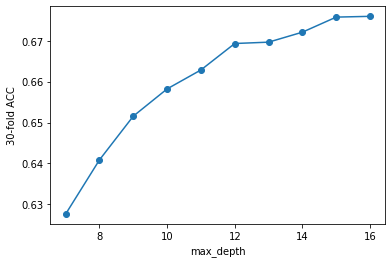

In [57]:
maxDepth = range(7,17)
tuned_parameters = {'max_depth': maxDepth}

gridRFR = GridSearchCV(RandomForestRegressor(n_estimators=200, max_features='log2'), param_grid=tuned_parameters, cv=30)
gridRFR.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(gridRFR.best_score_))
print("best parameters: {}".format(gridRFR.best_params_))

scores = np.array(gridRFR.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('30-fold ACC')

plt.show()

In [58]:
maxDepthOptimo = gridRFR.best_params_['max_depth']

RFR = RandomForestRegressor(max_depth=maxDepthOptimo-4,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

ytrainRFR = RFR.predict(X_train)
mseTrainModelRFR = mean_squared_error(y_train,ytrainRFR)

print('MSE Modelo RFR (train): %0.3g' % mseTrainModelRFR)
print('RMSE Modelo RFR (train): %0.3g' % np.sqrt(mseTrainModelRFR))

MSE Modelo RFR (train): 437
RMSE Modelo RFR (train): 20.9


best mean cross-validation score: -1604.093
best parameters: {'alpha': 12.589254117941675}


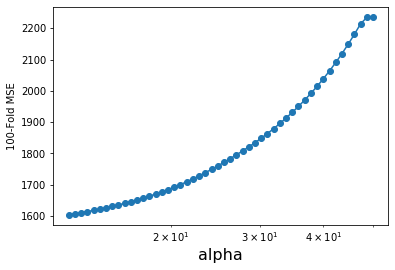

In [59]:
alpha_vector = np.logspace(1.1,1.7,50)
param_grid = {'alpha': alpha_vector }
gridLas = GridSearchCV(Lasso(), scoring='neg_mean_squared_error', param_grid=param_grid, cv=100)
gridLas.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(gridLas.best_score_))
print("best parameters: {}".format(gridLas.best_params_))

scores = -1*np.array(gridLas.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('100-Fold MSE')
plt.show()

In [60]:
alpha_optimo = gridLas.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(X_train,y_train)

ytrainLasso = lasso.predict(X_train)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))

MSE Modelo Lasso (train): 1.6e+03
RMSE Modelo Lasso (train): 40


In [61]:
y_train.describe()

count    10564.000000
mean        66.057554
std         55.909049
min          9.000000
25%         30.000000
50%         52.000000
75%         80.000000
max        800.000000
Name: Price, dtype: float64

Random Forest me da mucho mejores resultados que Lasso, así que seguiré trabajando con este algoritmo.

Voy a darle otro enfoque a las variables categóricas que teníamos. Esta vez usaré OneHotEncoder y recortaré con SelectKBest para evitar un desmadre de dimensionalidad usando chi2 para quedarme con las categorías más relevantes.

In [62]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2

X_train = train[['Bedrooms','Accommodates','Cleaning Fee','Room Type','Bathrooms',
                 'Guests Included','Security Deposit','Host Listings Count',
                 'Availability 60','Number of Reviews','Host Neighbourhood',
                 'Zipcode','Amenities','Review Scores Rating','Date Reviews']]

OHencoderneigh = OneHotEncoder().fit(train['Neighbourhood Cleansed'].values.reshape(-1,1))

neighbourhood = OHencoderneigh.transform(train['Neighbourhood Cleansed'].values.reshape(-1,1))
selected_neighb = SelectKBest(chi2, k=5).fit(neighbourhood.toarray(), y_train.to_numpy())
X_train = pd.DataFrame(np.column_stack([X_train, selected_neighb.transform(neighbourhood.toarray())]))

best mean cross-validation score: 0.675
best parameters: {'max_depth': 16}


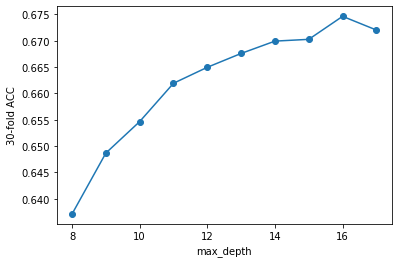

In [63]:
maxDepth = range(8,18)
tuned_parameters = {'max_depth': maxDepth}

gridRFR = GridSearchCV(RandomForestRegressor(n_estimators=200, max_features='log2'), param_grid=tuned_parameters, cv=30)
gridRFR.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(gridRFR.best_score_))
print("best parameters: {}".format(gridRFR.best_params_))

scores = np.array(gridRFR.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('30-fold ACC')

plt.show()

In [64]:
maxDepthOptimo = gridRFR.best_params_['max_depth']

RFRNeigh = RandomForestRegressor(max_depth=maxDepthOptimo-2,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

ytrainRFR = RFRNeigh.predict(X_train)
mseTrainModelRFR = mean_squared_error(y_train,ytrainRFR)

print('MSE Modelo RFR (train): %0.3g' % mseTrainModelRFR)
print('RMSE Modelo RFR (train): %0.3g' % np.sqrt(mseTrainModelRFR))

MSE Modelo RFR (train): 326
RMSE Modelo RFR (train): 18.1


Los resultados son más o menos iguales.

In [65]:
X_train = train[['Bedrooms','Accommodates','Cleaning Fee','Room Type','Bathrooms',
                 'Guests Included','Security Deposit','Host Listings Count',
                 'Availability 60','Number of Reviews',
                 'Zipcode','Amenities','Review Scores Rating','Date Reviews']]

OHencoderhostneigh = OneHotEncoder().fit(train['Host Neighbourhood'].values.reshape(-1,1))

host_neighbourhood = OHencoderhostneigh.transform(train['Host Neighbourhood'].values.reshape(-1,1))
selected_hostneig = SelectKBest(chi2, k=8).fit(host_neighbourhood.toarray(), y_train.to_numpy())
X_train = pd.DataFrame(np.column_stack([X_train, selected_hostneig.transform(host_neighbourhood.toarray())]))

best mean cross-validation score: 0.672
best parameters: {'max_depth': 17}


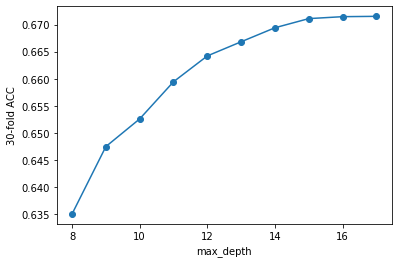

In [66]:
maxDepth = range(8,18)
tuned_parameters = {'max_depth': maxDepth}

gridRFR = GridSearchCV(RandomForestRegressor(n_estimators=200, max_features='log2'), param_grid=tuned_parameters, cv=30)
gridRFR.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(gridRFR.best_score_))
print("best parameters: {}".format(gridRFR.best_params_))

scores = np.array(gridRFR.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('30-fold ACC')

plt.show()

In [67]:
maxDepthOptimo = gridRFR.best_params_['max_depth']

RFRHostneigh = RandomForestRegressor(max_depth=maxDepthOptimo-3,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

ytrainRFR = RFRHostneigh.predict(X_train)
mseTrainModelRFR = mean_squared_error(y_train,ytrainRFR)

print('MSE Modelo RFR (train): %0.3g' % mseTrainModelRFR)
print('RMSE Modelo RFR (train): %0.3g' % np.sqrt(mseTrainModelRFR))

MSE Modelo RFR (train): 346
RMSE Modelo RFR (train): 18.6


Con Host Neighbourhood tengo más de lo mismo

In [68]:
X_train = train[['Bedrooms','Accommodates','Cleaning Fee','Room Type','Bathrooms',
                 'Guests Included','Security Deposit','Host Listings Count',
                 'Availability 60','Number of Reviews','Host Neighbourhood',
                 'Amenities','Review Scores Rating','Date Reviews']]

OHencoderzip = OneHotEncoder().fit(train['Zipcode'].values.reshape(-1,1))

zipcode = OHencoderzip.transform(train['Zipcode'].values.reshape(-1,1))
selected_zip = SelectKBest(chi2, k=10).fit(zipcode.toarray(), y_train.to_numpy())
X_train = pd.DataFrame(np.column_stack([X_train, selected_zip.transform(zipcode.toarray())]))

best mean cross-validation score: 0.659
best parameters: {'max_depth': 16}


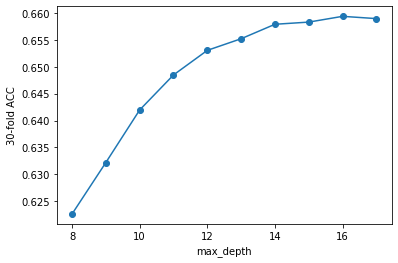

In [69]:
maxDepth = range(8,18)
tuned_parameters = {'max_depth': maxDepth}

gridRFR = GridSearchCV(RandomForestRegressor(n_estimators=200, max_features='log2'), param_grid=tuned_parameters, cv=30)
gridRFR.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(gridRFR.best_score_))
print("best parameters: {}".format(gridRFR.best_params_))

scores = np.array(gridRFR.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('30-fold ACC')

plt.show()

In [70]:
maxDepthOptimo = gridRFR.best_params_['max_depth']

RFRzip = RandomForestRegressor(max_depth=maxDepthOptimo-2,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

ytrainRFR = RFRzip.predict(X_train)
mseTrainModelRFR = mean_squared_error(y_train,ytrainRFR)

print('MSE Modelo RFR (train): %0.3g' % mseTrainModelRFR)
print('RMSE Modelo RFR (train): %0.3g' % np.sqrt(mseTrainModelRFR))

MSE Modelo RFR (train): 391
RMSE Modelo RFR (train): 19.8


Parece que éstas variables no nos van a mejorar gran cosa el modelo, solo van a sumar complejidad.

Ha llegado el momento de probar nuestros modelos con Test

In [71]:
test = pd.read_csv('./test.csv',sep=';', decimal='.')

y_test = test.Price

test = test[['Bedrooms','Accommodates','Cleaning Fee','Room Type','Bathrooms',
             'Guests Included','Security Deposit','Host Listings Count',
             'Availability 60','Number of Reviews','Host Neighbourhood',
             'Zipcode','Amenities','Review Scores Rating',
             'Property Type','First Review','Last Review',
             'Neighbourhood Cleansed']]

test.loc[test['Bedrooms'].isnull(), 'Bedrooms'] = test.loc[test['Bedrooms'].isnull(), 'Property Type'].apply(
    lambda x: 2 if x == 'House' else
    0 if x == 'Loft' else 1)

test['Room Type'] = test['Room Type'].apply(lambda x: {
    'Shared room': 1,
    'Private room': 2,
    'Entire home/apt': 3
}.get(x))

test['Amenities'] = test['Amenities'].apply(lambda x: len(str(x).split(',')))

test['Cleaning Fee'] = test['Cleaning Fee'].fillna(train['Cleaning Fee'].mean())
test['Bathrooms'] = test['Bathrooms'].fillna(train['Bathrooms'].mode()[0])
test['Review Scores Rating'] = test['Review Scores Rating'].fillna(train['Review Scores Rating'].mean())
test['Security Deposit'] = test['Security Deposit'].fillna(train['Security Deposit'].mean())
test['Host Listings Count'] = test['Host Listings Count'].fillna(train['Host Listings Count'].mean())

test.loc[~test['Neighbourhood Cleansed'].isin(checkneighcl), 'Neighbourhood Cleansed'] = 'Unknown'
test['Neighbourhood Cleansed'] = encoderNeighCl.transform(test['Neighbourhood Cleansed'])

test.loc[~test['Host Neighbourhood'].isin(checkhostneigh), 'Host Neighbourhood'] = 'Unknown'
test['Host Neighbourhood'] = encoderHostNeigh.transform(test['Host Neighbourhood'])

In [72]:
test['Zipcode'] = test['Zipcode'].fillna(0)
test['Zipcode'] = test['Zipcode'].astype(int)

# Me cargo todos los que no empiezen por 28 (obligatorio para Madrid)
test.loc[test['Zipcode']>28999, 'Zipcode'] = 0
test.loc[test['Zipcode']<28000, 'Zipcode'] = 0

# Unseen labels
test.loc[~test['Zipcode'].isin(zipstocheck), 'Zipcode'] = 0

test['Zipcode'] = encoderZipcode.transform(test['Zipcode'])

In [73]:
test['First Review'] = test['First Review'].fillna(0)
test['First Review'] = test['First Review'].apply(lambda x: int(str(x).split('-')[0])-2009)
test['First Review'] = test['First Review'].apply(lambda x: 0 if x not in range(0,10) else x)

test['Last Review'] = test['Last Review'].fillna(0)
test['Last Review'] = test['Last Review'].apply(lambda x: int(str(x).split('-')[0])-2011)
test['Last Review'] = test['Last Review'].apply(lambda x: 0 if x not in range(0,10) else x)

test['Date Reviews'] = test['First Review']*test['Last Review']

In [74]:
test = test.drop(columns=['Property Type','First Review','Last Review'])
test = test.apply(lambda x: pd.to_numeric(x))

In [75]:
X_test = test.drop(columns=['Neighbourhood Cleansed'])

In [76]:
ytestRFR = RFR.predict(X_test)
mseTestModelRFR = mean_squared_error(y_test,ytestRFR)

print('MSE Modelo RFR (test): %0.3g' % mseTestModelRFR)
print('RMSE Modelo RFR (test): %0.3g' % np.sqrt(mseTestModelRFR))

MSE Modelo RFR (test): 1.13e+03
RMSE Modelo RFR (test): 33.6


In [77]:
big = neighbourhood.shape[1]
neighbourhood = OHencoderneigh.transform(test['Neighbourhood Cleansed'].values.reshape(-1,1))
small = neighbourhood.shape[1]

In [78]:
# Añado columnas de 0s en las categorías que no aparecen para evitar errores
neighbourhood = np.column_stack([neighbourhood.toarray(), np.zeros((2642,big-small))])
X_test = pd.DataFrame(np.column_stack([X_test, selected_neighb.transform(neighbourhood)]))

In [79]:
ytestRFR = RFRNeigh.predict(X_test)
mseTestModelRFR = mean_squared_error(y_test,ytestRFR)

print('MSE Modelo RFR (test): %0.3g' % mseTestModelRFR)
print('RMSE Modelo RFR (test): %0.3g' % np.sqrt(mseTestModelRFR))

MSE Modelo RFR (test): 1.11e+03
RMSE Modelo RFR (test): 33.3


In [80]:
X_test = test.drop(columns=['Neighbourhood Cleansed', 'Host Neighbourhood'])

In [81]:
big = host_neighbourhood.shape[1]
host_neighbourhood = OHencoderhostneigh.transform(test['Host Neighbourhood'].values.reshape(-1,1))
small = host_neighbourhood.shape[1]

In [82]:
host_neighbourhood = np.column_stack([host_neighbourhood.toarray(), np.zeros((2642,big-small))])
X_test = pd.DataFrame(np.column_stack([X_test, selected_hostneig.transform(host_neighbourhood)]))

In [83]:
ytestRFR = RFRHostneigh.predict(X_test)
mseTestModelRFR = mean_squared_error(y_test,ytestRFR)

print('MSE Modelo RFR (test): %0.3g' % mseTestModelRFR)
print('RMSE Modelo RFR (test): %0.3g' % np.sqrt(mseTestModelRFR))

MSE Modelo RFR (test): 1.15e+03
RMSE Modelo RFR (test): 33.9


In [84]:
X_test = test.drop(columns=['Neighbourhood Cleansed', 'Zipcode'])

In [85]:
big = zipcode.shape[1]
zipcode = OHencoderzip.transform(test['Zipcode'].values.reshape(-1,1))
small = zipcode.shape[1]

In [86]:
zipcode = np.column_stack([zipcode.toarray(), np.zeros((2642,big-small))])
X_test = pd.DataFrame(np.column_stack([X_test, selected_zip.transform(zipcode)]))

In [87]:
ytestRFR = RFRzip.predict(X_test)
mseTestModelRFR = mean_squared_error(y_test,ytestRFR)

print('MSE Modelo RFR (test): %0.3g' % mseTestModelRFR)
print('RMSE Modelo RFR (test): %0.3g' % np.sqrt(mseTestModelRFR))

MSE Modelo RFR (test): 1.16e+03
RMSE Modelo RFR (test): 34.1


In [88]:
y_test.describe()

count    2642.000000
mean       65.337245
std        56.351189
min        10.000000
25%        32.000000
50%        51.000000
75%        80.000000
max       875.000000
Name: Price, dtype: float64

Vistos los resultados podemos decir que de todos los modelos que se han probado, el modelo más simple de RandomForestRegressor (el que no utiliza variables codificadas con OHE) sería el más óptimo para resolver este problema (a pesar de que los resultados son bastante mediocres).

In [89]:
X_test = test.drop(columns=['Neighbourhood Cleansed'])

ytestRFR = RFR.predict(X_test)
mseTestModelRFR = mean_squared_error(y_test,ytestRFR)

print('MSE Modelo RFR (test): %0.3g' % mseTestModelRFR)
print('RMSE Modelo RFR (test): %0.3g' % np.sqrt(mseTestModelRFR))

MSE Modelo RFR (test): 1.13e+03
RMSE Modelo RFR (test): 33.6


In [90]:
print(f'media real: {np.mean(y_test)} - media predicciones: {np.mean(ytestRFR)}\n')

for r,p in zip(y_test,ytestRFR):
    print(f'real: {r} - estimado: {p}')

media real: 65.33724451173353 - media predicciones: 65.39894686514455

real: 40.0 - estimado: 38.07657786598651
real: 26.0 - estimado: 34.552288400756574
real: 18.0 - estimado: 33.55811194666309
real: 68.0 - estimado: 99.91977589824228
real: 35.0 - estimado: 59.72097814519492
real: 64.0 - estimado: 71.8431796860239
real: 90.0 - estimado: 60.1202692352363
real: 76.0 - estimado: 73.58555591889218
real: 50.0 - estimado: 61.45346570558501
real: 70.0 - estimado: 84.25058153944057
real: 22.0 - estimado: 29.09005677317135
real: 74.0 - estimado: 63.96157241210767
real: 50.0 - estimado: 37.031704957501425
real: 105.0 - estimado: 76.64455040270835
real: 55.0 - estimado: 25.67086916106171
real: 65.0 - estimado: 72.00729293286663
real: 55.0 - estimado: 52.57328830203456
real: 40.0 - estimado: 35.72420581867922
real: 20.0 - estimado: 33.424186392486966
real: 11.0 - estimado: 12.183658795395678
real: 23.0 - estimado: 32.86762536423698
real: 60.0 - estimado: 60.06084538242397
real: 66.0 - estimado: 8